# PyTorch3D Build Helper (Windows, Torch 2.6.0 + CUDA 12.4)

Guía paso a paso para preparar **Windows** y poder **compilar PyTorch3D** contra `torch==2.6.0+cu124`.

---
## 1) Instalar toolchain necesario (fuera de Python)
1. **CUDA Toolkit 12.4** (no solo el driver):
   - Durante la instalación, marca **Add to PATH** y **Visual Studio Integration**.
   - Tras instalar, verifica que existan rutas como `C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v12.4\\bin\\nvcc.exe`.
2. **Microsoft Visual Studio Build Tools 2022**:
   - Abre el instalador y elige la carga de trabajo **Desktop development with C++**.
   - En **Individual components**, asegúrate de incluir:
     - **MSVC v143 - VS 2022 C++ x64/x86 build tools**
     - **Windows 11 SDK (10.0.22621 o superior)**
     - **C++ CMake tools for Windows**
   - Termina la instalación y **reinicia** la PC si lo pide.

## 2) Configurar variables de entorno (si no se agregaron solas)
- Añade a **PATH** (para tu usuario o sistema):
  - `C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v12.4\\bin`
  - `C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v12.4\\libnvvp`
- Define **CUDA_HOME** y **CUDA_PATH** a `C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v12.4`.
- Asegúrate de abrir **"x64 Native Tools Command Prompt for VS 2022"** o **Developer PowerShell for VS** antes de lanzar Jupyter (esto garantiza que `cl.exe` esté en PATH).

## 3) Verificación dentro de Python
Ejecuta las siguientes celdas. Si `nvcc` y `cl.exe` siguen sin aparecer, abre el Notebook desde el **entorno de VS** mencionado.


In [1]:
import shutil, subprocess
print('nvcc:', shutil.which('nvcc'))
print('cl.exe:', shutil.which('cl'))
try:
    out = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
    print(out.stdout or out.stderr)
except Exception as e:
    print('nvcc no ejecuta:', e)

nvcc: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.4\bin\nvcc.EXE
cl.exe: C:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.44.35207\bin\HostX64\x64\cl.EXE
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Tue_Feb_27_16:28:36_Pacific_Standard_Time_2024
Cuda compilation tools, release 12.4, V12.4.99
Build cuda_12.4.r12.4/compiler.33961263_0



## 4) Preparar `TORCH_CUDA_ARCH_LIST`
Se utiliza para compilar kernels solo para arquitecturas necesarias (tu RTX 3060 es **8.6**).

In [ ]:
import os, torch
arches = {'8.6'}  # RTX 3060
# Puedes añadir otras si deseas compatibilidad cruzada
os.environ['TORCH_CUDA_ARCH_LIST'] = ';'.join(sorted(arches))
print('TORCH_CUDA_ARCH_LIST=', os.environ['TORCH_CUDA_ARCH_LIST'])


## 5) Instalar dependencias y compilar **PyTorch3D**
Recomendado hacerlo **una sola vez**. Si falla, lee el apartado de **Solución de problemas**.

In [ ]:
%pip install -U pip setuptools wheel ninja cmake
%pip install -U fvcore iopath
%pip install -U open3d trimesh pyrender


In [ ]:
%pip install "git+https://github.com/facebookresearch/pytorch3d.git" --verbose


## 6) Smoke test rápido
Si la instalación terminó bien, este test debería renderizar un icosphere.

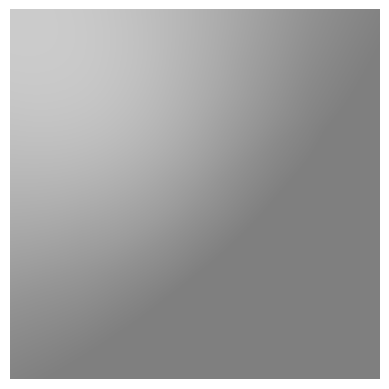

In [2]:
import torch
from pytorch3d.utils import ico_sphere
from pytorch3d.renderer import (
    PerspectiveCameras, RasterizationSettings, MeshRenderer, MeshRasterizer,
    SoftPhongShader, PointLights, TexturesVertex
)
from pytorch3d.structures import Meshes
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base = ico_sphere(level=3, device=device)
tex = TexturesVertex(verts_features=torch.ones_like(base.verts_packed())[None])
mesh = Meshes(verts=[base.verts_packed()], faces=[base.faces_packed()], textures=tex).to(device)
cameras = PerspectiveCameras(device=device)
raster = RasterizationSettings(image_size=256)
lights = PointLights(device=device, location=[[2,2,2]])
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster),
    shader=SoftPhongShader(device=device, cameras=cameras, lights=lights)
)
img = renderer(mesh)
plt.imshow(img[0, ..., :3].detach().cpu().numpy()); plt.axis('off'); plt.show()


---
## Solución de problemas comunes
- **`nvcc: not found`**: no está instalado el Toolkit o no está en PATH. Ver secciones 1 y 2.
- **`cl.exe: not found`**: debes abrir el Notebook desde *x64 Native Tools Command Prompt for VS 2022* o añadir las rutas de MSVC a PATH.
- **Errores de encabezados CUDA (`cuda_runtime_api.h`)**: suele ser falta de Toolkit o `CUDA_PATH` incorrecto.
- **LTO/Link errors**: intenta `pip install --no-build-isolation` o `set CMAKE_GENERATOR=Ninja` antes de instalar; asegúrate de tener `ninja`.
- **OOM durante build**: cierra apps pesadas y baja el número de jobs: `set MAX_JOBS=4` en la misma consola antes del `pip install`.
